# TM10007 Assignment ADNI Dataset

Bram Gerritse 4462599  
Saskia Bijl 4439457    
Karan Ramsodit  
Enzo Kerkhof 44488555


### Install git repo:

In [15]:
# Run this to use from colab environment to install git repo
!pip install -q --upgrade git+https://github.com/Enzo-Kerkhof/TM10007_PROJECT.git@Enzo_testing

# Use the @ to determine what branch to install. Don't use to install master.

### Import used libraries

In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import ttest_ind
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics
from sklearn import feature_selection
from sklearn import ensemble
from sklearn import linear_model

### Data loading and analysis

The dataset ABNI contains the following:

The number of samples/patients = 855
The number of columns/features = 267



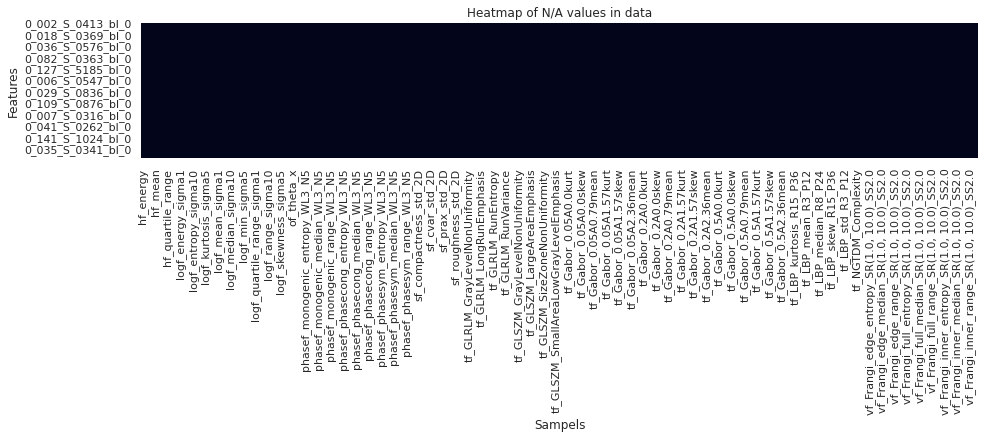

In [17]:
# Import premade data loading function
from adni.load_data import load_data

data = load_data()

# Drop labels from dataframe
X = data.drop(['label'], axis=1)

print('The dataset ABNI contains the following:\n')
print(f'The number of samples/patients = {len(X.index)}')
print(f'The number of columns/features = {len(X.columns)}\n')

# Heatmap to check number of n/a
pd.options.mode.use_inf_as_na = True
plt.figure(figsize=(15, 2.5))
sns.heatmap(X.isnull(), cbar=False)
plt.title('Heatmap of N/A values in data')
plt.xlabel('Sampels')
plt.ylabel('Features')
plt.show()

### Data preprocessing and splitting

In [0]:
# Binerize labels AD = 1, CN = 0
Y = preprocessing.label_binarize(data['label'], ['CN', 'AD'])
Y = [i[0] for i in Y]

# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2)

# Reshape and convert to arrays
y_train=np.asarray(y_train).reshape([len(y_train),])
y_test=np.asarray(y_test).reshape([len(y_test),])
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()

### Feature selection

Apply 2-sampled T-test for feature selection 

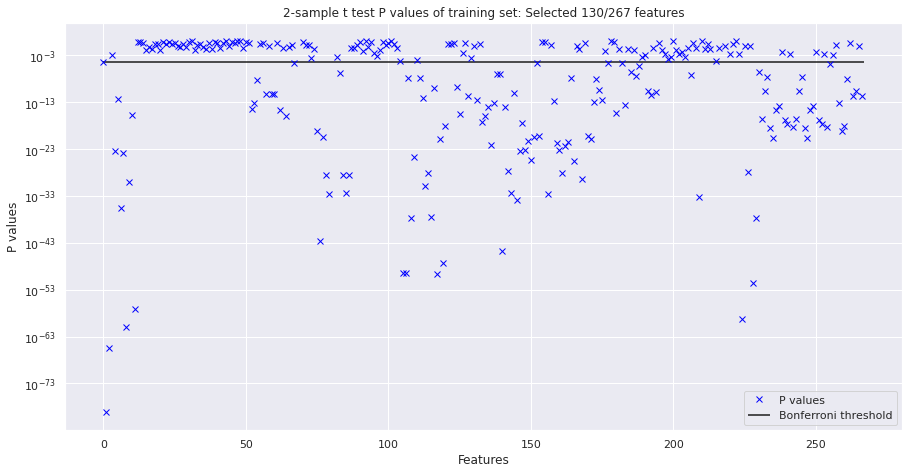

In [19]:
# Create function to get indices
np.seterr(invalid='ignore')
get_indices = lambda dataToMatch, inputData: [i for (y, i) in zip(inputData, range(len(inputData))) 
                                              if dataToMatch == y]

# Calculate Bonferroni correction
Bonferroni_corrected_alpha = 0.01/(X.shape[1])

# Get indices of labels
ad_samplsIndex = get_indices(1, y_train)
cn_sampleIndex = get_indices(0, y_train)

ad_data = X_train[ad_samplsIndex, :]
cn_data = X_train[cn_sampleIndex, :]

# Preform t-test
[t_values, p_values]=ttest_ind(ad_data, cn_data)

get_indices_smallerThen = lambda dataToMatch, inputData: [i for (y, i) in zip(inputData, range(len(inputData))) 
                                                          if dataToMatch <= y]

# Get significant p values only
significant_p_valueIndices = get_indices_smallerThen(Bonferroni_corrected_alpha, p_values)

# Feature selected dataset
X_train_selected = X_train[:,significant_p_valueIndices]
X_test_selected = X_test[:,significant_p_valueIndices]

# Show p values and the bonferroni threshold
plt.figure(figsize=(15, 7.5))
plt.plot(p_values, 'x', color='blue', label='P values')
plt.hlines(Bonferroni_corrected_alpha, 0, X.shape[1], label='Bonferroni threshold')
plt.xlabel('Features')
plt.ylabel('P values')
plt.yscale('log')
plt.title(f'2-sample t test P values of training set: Selected {X_train_selected.shape[1]}/{X.shape[1]} features')
plt.legend()
plt.show()


### Feature scaling

Scale features using the Min-Max scaler for the classifiers.
A plot of the mean and standard deviation of all selected features before and after scaling is shown.

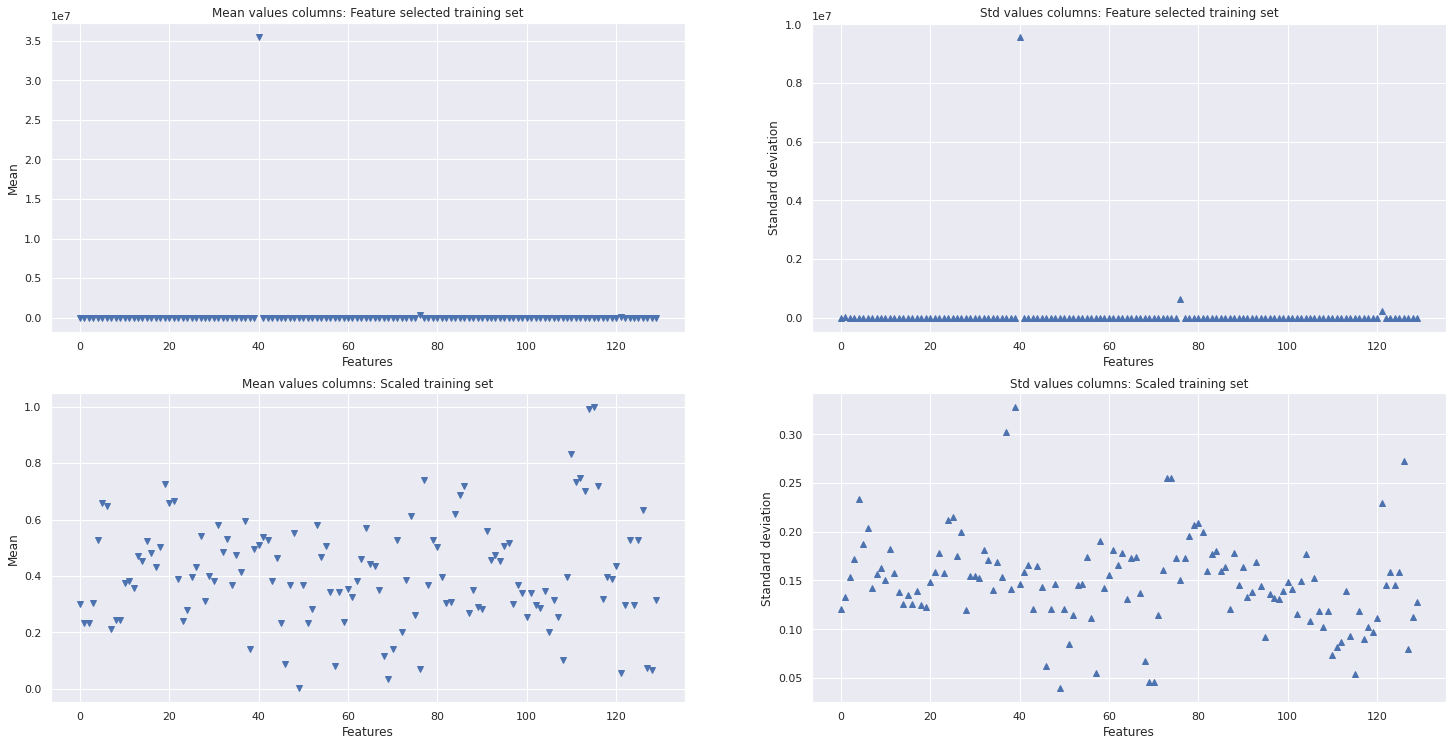

In [20]:
# Scale the data
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_selected)
X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Retrieve data statistics
data_statistics_selected = pd.DataFrame(X_train_selected).describe()
data_statistics_scaled = pd.DataFrame(X_train_scaled).describe()

# Plot figure of mean and std before and after scaling
fig = plt.figure(figsize=(25,12.5))

ax = fig.add_subplot(221)
ax.plot(range(X_train_selected.shape[1]), data_statistics_selected.loc['mean',:], 'v')
ax.set_xlabel('Features')
ax.set_ylabel('Mean')
ax.set_title("Mean values columns: Feature selected training set")

ax = fig.add_subplot(222)
ax.plot(range(X_train_selected.shape[1]), data_statistics_selected.loc['std',:], '^')
ax.set_xlabel('Features')
ax.set_ylabel('Standard deviation')
ax.set_title("Std values columns: Feature selected training set")

ax = fig.add_subplot(223)
ax.plot(range(X_train_scaled.shape[1]), data_statistics_scaled.loc['mean',:], 'v')
ax.set_xlabel('Features')
ax.set_ylabel('Mean')
ax.set_title("Mean values columns: Scaled training set")

ax = fig.add_subplot(224)
ax.plot(range(X_train_scaled.shape[1]), data_statistics_scaled.loc['std',:], '^')
ax.set_xlabel('Features')
ax.set_ylabel('Standard deviation')
ax.set_title("Std values columns: Scaled training set")
plt.show()

### Preform Principal Component Analysis
PCA on scaled and selected features. Plot the Cumulative explained variance to see the added variance per eigenvalue.

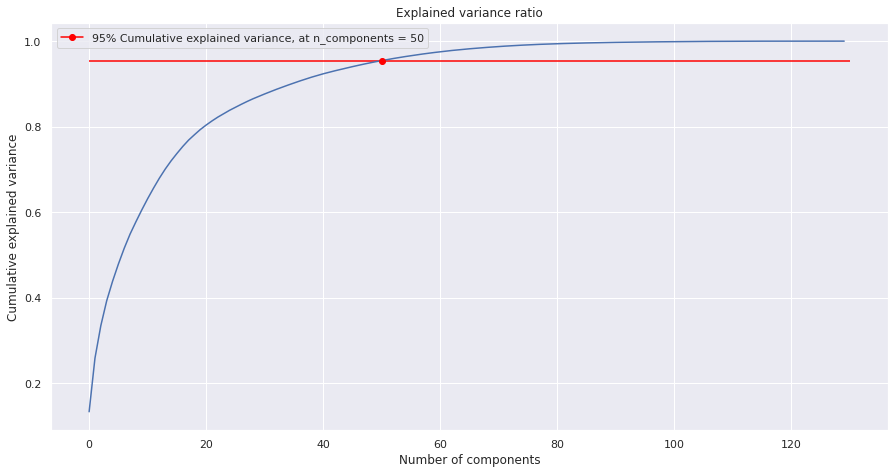

In [21]:
# Perform a PCA
pca = decomposition.PCA()
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1

plt.figure(figsize=(15, 7.5))
plt.plot(cumsum)
plt.plot(d, cumsum[d],'-o', color='red', label=f'95% Cumulative explained variance, at n_components = {d}')
plt.hlines(cumsum[d], 0, cumsum.shape[0], color='red')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance ratio')
plt.legend()
plt.show()

pca = decomposition.PCA(n_components=d)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

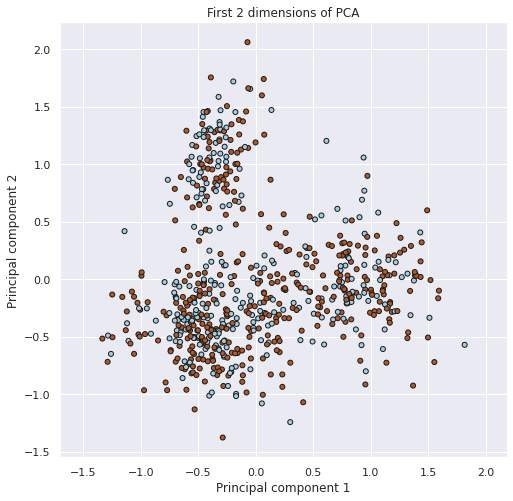

In [22]:
# Plot the first two components of the PCA with the true labels as colours
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o',
            c=y_train, s=25, edgecolor='k',
            cmap=plt.cm.Paired);
plt.title('First 2 dimensions of PCA')
plt.xlabel('Principal component 1');
plt.ylabel('Principal component 2');
plt.axis('equal');

As seen in the plot above, the problem is multi dimentional. The first 2 components of the PCA have a very large overlap in the scatterplot.


# Fit classifiers
### Try different classifiers (and different hyperparameters).

### K-NearestNeighbor with optimal N
First plot to show the train and validation scores with arbitrary N.
Then an implemented crossvalidation gridsearch to choose the optimal N.

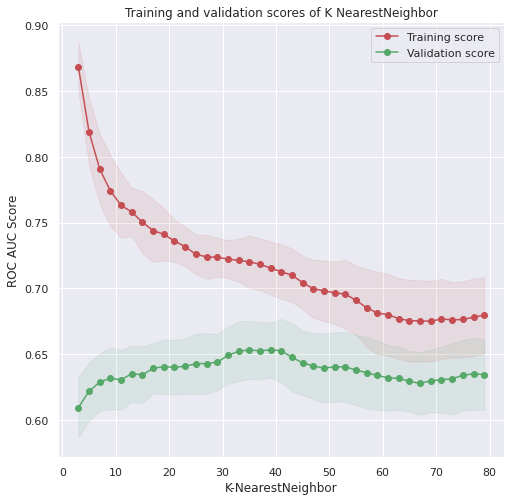

In [23]:
k_list = list(range(3, 80, 2))
all_train = []
all_test = []

# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.5)

for train_index, test_index in sss.split(X_train, y_train):
    train_scores = []
    test_scores = []
    
    split_X_train = X_train[train_index]
    split_y_train = y_train[train_index]
    split_X_test = X_train[test_index]
    split_y_test = y_train[test_index]

    for k in k_list:
        clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        train_proba = clf_knn.predict_proba(split_X_train)[:, 1]
        test_proba = clf_knn.predict_proba(split_X_test)[:, 1]
        
        score_train = metrics.roc_auc_score(split_y_train, train_proba)
        score_test = metrics.roc_auc_score(split_y_test, test_proba)
        

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)
    

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Validation score")
ax.set_xlabel('K-NearestNeighbor')
ax.set_ylabel('ROC AUC Score')
ax.set_title('Training and validation scores of K NearestNeighbor')
ax.legend()
plt.show()

In [24]:
# Create a stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train, y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = y_train[validation_index]
    
    X_validation_test = X_train_pca[test_index]
    y_validation_test = y_train[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(3, 80, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")


# Fit kNN
clf = neighbors.KNeighborsClassifier(n_neighbors=optimal_n)
clf.fit(X_train, y_train)

probabilities_test = clf.predict_proba(X_test)
scores_test = probabilities_test[:, 1]

# Print result
auc = metrics.roc_auc_score(y_test, scores_test)
print(f'THe AUC on the test set is {auc} using a {clf.n_neighbors}-NearestNeighbor classifier')

The optimal N=43
THe AUC on the test set is 0.7701015965166909 using a 43-NN classifier


##Random forest classifier
Randomized crossvalidation with a few hyperparameters in order to find an optimal random forest for the training set.

In [27]:
# Hyperparameters to optimizatize
param_distributions = {'n_estimators': range(20, 110),
                       'max_depth': range(1, 50),
                       'max_leaf_nodes': range(20, 110)
                       }

# Randomized search crossvalidation
clf = model_selection.RandomizedSearchCV(ensemble.RandomForestClassifier(), param_distributions, cv=10, n_iter=100)
clf.fit(X_train, y_train)

# Test score ROC AUC
probabilities_test = clf.best_estimator_.predict_proba(X_test)
scores_test = probabilities_test[:, 1]
auc = metrics.roc_auc_score(y_test, scores_test)

# Print results
print(f'\nThe best parameters for this dataset are:\n')
print(f'\t {clf.best_params_}')
print('\t The other parameters are left default.')
print(f'\nThe AUC on the test set is {auc} using a {clf.best_estimator_.n_estimators}-Tree RF classifier')




 The best parameters for dataset are:
	 {'n_estimators': 55, 'max_leaf_nodes': 26, 'max_depth': 32}
	 The other parameters are left default.
The AUC on the test set is 0.755732946298984 using a 55-Tree RF classifier


### Logistic Regression model
Grid search crossvalidation in order to find an optimal logistic regression classifier.

In [0]:
classifier = linear_model.LogisticRegression()

param_grid = [
              {'penalty' : ['l2'],
               'C' : np.arange(0.0001, 1, 0.0001),
               'solver' : ['sag', 'saga']
               }]

cls = model_selection.GridSearchCV(classifier, param_grid, cv=4, scoring='roc_auc')
cls.fit(X_train, y_train)

predictions=cls.best_estimator_.predict(X_test)

print(f'\nThe best parameters for this dataset are:\n')
print(f'\t {cls.best_params_}')
print('\t The other parameters are left default.')
print("\nConfusion matrix for Logistic Regression Classifier:\n")
print(metrics.confusion_matrix(y_pred=predictions, y_true=y_test))
print("\nClassification report for Logistic Regression Classifier:\n")
print(metrics.classification_report(y_pred=predictions, y_true=y_test))

### Support vector machine

In [0]:
# Hyperparameters to optimizatize
param_distributions = {'C': range(0.01, 2, 0.02),
                       'gamma': ['scale', 'auto']
                       }

# Randomized search crossvalidation
clf = model_selection.RandomizedSearchCV(svm.SVC(), param_distributions, cv=10, n_iter=100)
clf.fit(X_train, y_train)

# Test score ROC AUC
probabilities_test = clf.best_estimator_.predict_proba(X_test)
scores_test = probabilities_test[:, 1]
auc = metrics.roc_auc_score(y_test, scores_test)

# Print results
print(f'\nThe best parameters for this dataset are:')
print(f'\t {clf.best_params_}')
print('\t The other parameters are left default.')
print(f'The AUC of this estimator is: {auc}')